<a href="https://colab.research.google.com/github/HeitorExp/Desafio-de-Codigo--DIO/blob/main/notebooks/transfer-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importação das bibliotecas

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
tf.__version__

'2.15.0'

### Relacionando com o google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Extraindo o arquivo zip do drive

In [3]:
# realizando a extração do arquivo zip.
path = '/content/drive/MyDrive/agora_vai/cat_dog.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

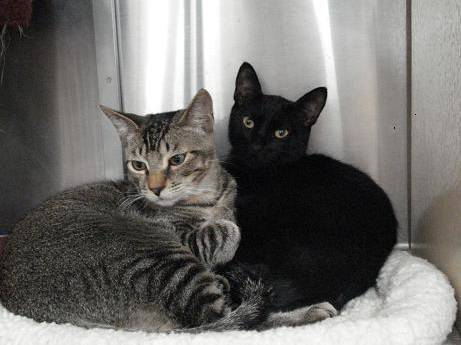

In [7]:
# visualizando um imagem da pasta de treinamento cat.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.8.jpg')

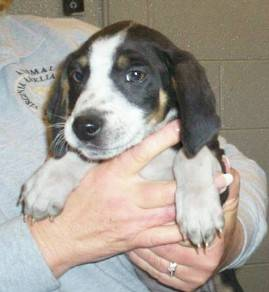

In [9]:
# visualizando uma imagem da pasta de treinamento dog.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/dog/dog.10.jpg')


    Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir diversidade de amostra artificialmente aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como inversão horizontal aleatória ou pequenas rotações aleatórias e zoom nas imagens. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento enquanto diminui o overfitting.
    Precisamos também normalizar e redimensionar todas as imagens para o mesmo padrão, para isso irei utilizar o método ImageDataGenerator conforme abaixo.


In [10]:
# realizando o redimensionamento e a normalização no conjunto de treinamento.
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/cat_dog/training_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


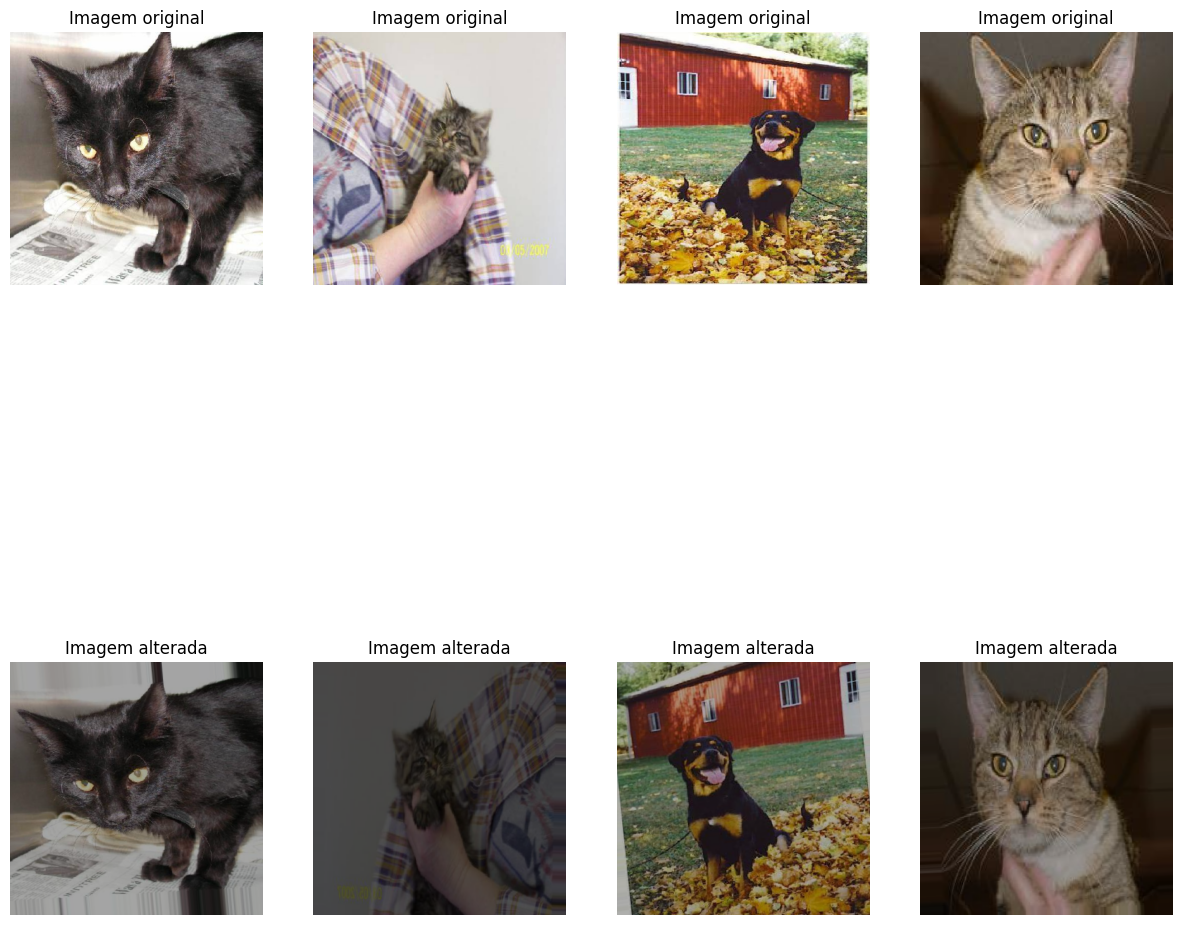

In [11]:
# alterando as imagens.
datagen = ImageDataGenerator(
        rotation_range=7, # Rotação
        zoom_range=0.2, # aplicano 20% de zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brilho

# imagem sem alteração.
datanorm = ImageDataGenerator()

# conjunto com alterações
treino_alterado = datagen.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400), # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  class_mode="binary", # classes
                  seed=2020 # para que os resultados sejam reproduzidos
                  )

# conjunto sem sofrer alterações
treino_normal = datanorm.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400),
                  color_mode="rgb",
                  batch_size=1,
                  class_mode="binary",
                  seed=2020
                  )

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

# plotando 5 imagens
for i in range(4):

  # convertendo a imagem para inteiro
  image = next(treino_alterado)[0].astype('uint8')
  image2 = next(treino_normal)[0].astype('uint8')

  # alterando o formato (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = np.squeeze(image)
  image2 = np.squeeze(image2)


  # plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')

In [12]:
# realizando o redimensionamento e a normalização no conjunto de teste.
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/cat_dog/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


In [13]:
# carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# informações das camadas do modelo base.
modelo_base.summary()

In [16]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)


154

In [15]:
# congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
  layer.trainable = False

In [17]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [18]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)


In [19]:
network = Model(inputs = modelo_base.input, outputs = head_model)

In [ ]:
network.summary()

In [21]:
len(network.layers)

160

In [23]:
# compilando o modelo

network.compile(loss = 'categorical_crossentropy', optimizer = 'Adam',
                metrics = ['accuracy'])


In [28]:
# realizando o treinamento em apenas 10 epocas

historico = network.fit(dataset_treinamento, epochs=10)

Epoch 1/10
32/32 [==============================] - 20s 635ms/step - loss: 0.0509 - accuracy: 0.9808
Epoch 2/10
32/32 [==============================] - 21s 651ms/step - loss: 0.0352 - accuracy: 0.9865
Epoch 3/10
32/32 [==============================] - 24s 760ms/step - loss: 0.0307 - accuracy: 0.9880
Epoch 4/10
32/32 [==============================] - 31s 961ms/step - loss: 0.0389 - accuracy: 0.9872
Epoch 5/10
32/32 [==============================] - 21s 650ms/step - loss: 0.0386 - accuracy: 0.9875
Epoch 6/10
32/32 [==============================] - 35s 1s/step - loss: 0.0347 - accuracy: 0.9862
Epoch 7/10
32/32 [==============================] - 20s 628ms/step - loss: 0.0259 - accuracy: 0.9890
Epoch 8/10
32/32 [==============================] - 20s 628ms/step - loss: 0.0325 - accuracy: 0.9885
Epoch 9/10
32/32 [==============================] - 22s 677ms/step - loss: 0.0437 - accuracy: 0.9820
Epoch 10/10
32/32 [==============================] - 21s 655ms/step - loss: 0.0277 - accuracy:

In [30]:
# avaliando a rede neural com o conjunto de teste
network.evaluate(dataset_teste)

1000/1000 [==============================] - 9s 9ms/step - loss: 0.1193 - accuracy: 0.9680


[0.11925959587097168, 0.9679999947547913]

In [32]:
# realizando as previsões no conjunto de teste

previsoes = network.predict(dataset_teste)
previsoes

1000/1000 [==============================] - 8s 8ms/step


array([[1.03949115e-01, 8.96050870e-01],
       [9.99764502e-01, 2.35527128e-04],
       [1.00000000e+00, 2.82509627e-10],
       ...,
       [4.53586876e-01, 5.46413064e-01],
       [1.16671121e-03, 9.98833239e-01],
       [2.12961897e-08, 1.00000000e+00]], dtype=float32)

In [33]:
# previsões para o conjunto de teste

previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] #10 primeiros registros


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
# classificação real do conjunto de teste

dataset_teste.classes[:10] #10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
# usando a função de acurácia do sklearn apenas para comparar se os resultados estão corretos

from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.968

In [37]:
network.evaluate(dataset_teste)

1000/1000 [==============================] - 14s 14ms/step - loss: 0.1193 - accuracy: 0.9680


[0.11925959587097168, 0.9679999947547913]

In [ ]:
dataset_treinamento.class_indices

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)

fig, ax = plt.subplots(figsize = (7,7))

sns.heatmap(cm,cmap = "Blues", annot = True, fmt = ".1f", cbar = False)

ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks_labels(np.arange(2) + .5, labels = xticks_labels)

plt.xlabel('')
plt.ylabel('')

title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.title(title, loc = 'left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

### Salvando e carregando a rede neural

In [ ]:
# salvando os parâmetros do modelo

model_json = network.to_json()
with open ('network.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
# salvando os pesos das camadas

from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [ ]:
# visualizando o arquivo json

with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

In [ ]:
# carregando o modelo salvo

network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded = load_weights('weights.hdf5')
network_loaded = compile(loss = 'categorical_crossentropy', optimizer= 'Adam',
                         metrics = ['accuracy'])

In [ ]:
# conferindo as informações das camadas

network_loaded.summary()

### Classficação de uma única imagem

In [ ]:
# carregando uma imagem

imagem = cv2.imread('/content/cat_dog/test_set/dog/dog.3506.jpg')

In [ ]:
cv2_imshow(imagem)

In [ ]:
# alterando para o tamanho padrão e rotacionando a imagem para dificultar a classificação

imagem = cv2.resize(imagem, (128,128))
imagem = cv2.rotate(imagem, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(imagem)

In [ ]:
# normalizando a imagem

imagem = imagem / 255
imagem

In [ ]:
# conferindo o formato

imagem.shape

In [ ]:
 # necessário realizar o reshape para que o modelo entenda o formato

 imagem = imagem.reshape(1, 128, 128, 3)

In [ ]:
# realizando a previsão

previsao = network_loaded(imagem)
previsao

In [ ]:
previsao = np.argmax(previsao)
previsao

In [ ]:
dataset_teste.class.indices

In [ ]:
if previsao == 0:
  print("O modelo identificou que o animal é um gato")
else:
  print("O modelo identificou que o animal é um cachorro")